In [80]:
import numpy as np
import pandas as pd
import networkx as nx
import collections 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, GridSearchCV, ParameterGrid
import multiprocessing
import warnings
import sklearn
print(sklearn.__version__) 

1.0.1


In [87]:
df = pd.read_csv("../results/results_SmallFog_X/samples.csv")
df.head()

,sim,app,currentFlavour,action,HWreq,OdiffReqChannels,OreqChannels,OsumReq,OavgReq,OsumLat,...,FavgReq,FsumLat,FavgLat,FHWtotal,FHWfree,Futilization,Fdegree,Fcentrality,Fnusers,fit
0,0,1,medium,undeploy,10,1,1,2,2.0,4,...,0.0,0,0.0,2.0,0,1.000000,1,0.076923,1,0.0
1,0,1,medium,small,10,1,1,3,3.0,4,...,1.0,4,4.0,2.0,1,0.500000,1,0.076923,1,1.0
2,0,1,medium,large,10,1,1,1,1.0,4,...,2.0,4,4.0,2.0,-3,2.500000,1,0.076923,1,0.0
3,0,1,small,undeploy,5,1,1,2,2.0,7,...,0.0,0,0.0,6.0,4,0.333333,4,0.307692,1,0.0
4,0,1,small,replicate,5,1,1,1,1.0,7,...,0.0,0,0.0,6.0,4,0.333333,4,0.307692,1,1.0


In [88]:
df.loc[0]

sim                        0
app                        1
currentFlavour        medium
action              undeploy
HWreq                     10
OdiffReqChannels           1
OreqChannels               1
OsumReq                    2
OavgReq                  2.0
OsumLat                    4
OavgLat                  4.0
HWtotal                  2.0
HWfree                     0
utilization              1.0
degree                     1
centrality          0.076923
nusers                     1
FHWreq                    10
FdiffReqChannels           0
FreqChannels               0
FsumReq                    0
FavgReq                  0.0
FsumLat                    0
FavgLat                  0.0
FHWtotal                 2.0
FHWfree                    0
Futilization             1.0
Fdegree                    1
Fcentrality         0.076923
Fnusers                    1
fit                      0.0
Name: 0, dtype: object

In [3]:
#dummies
actions_labels = ["undeploy","small","medium","large","migrate","replicate"]
actions = np.arange(len(actions_labels)) #dummies
print(actions)
df["action"] = df["action"].map(lambda x:actions_labels.index(x))
df["currentFlavour"] = df["currentFlavour"].map(lambda x:actions_labels.index(x))

[0 1 2 3 4 5]


In [4]:
df.head()

,sim,app,currentFlavour,action,HWreq,OdiffReqChannels,OreqChannels,OsumReq,OavgReq,OsumLat,...,FavgReq,FsumLat,FavgLat,FHWtotal,FHWfree,Futilization,Fdegree,Fcentrality,Fnusers,fit
0,0,1,2,0,10,1,1,2,2.0,4,...,0.0,0,0.0,2.0,0,1.000000,1,0.076923,1,0.0
1,0,1,2,1,10,1,1,3,3.0,4,...,1.0,4,4.0,2.0,1,0.500000,1,0.076923,1,1.0
2,0,1,2,3,10,1,1,1,1.0,4,...,2.0,4,4.0,2.0,-3,2.500000,1,0.076923,1,0.0
3,0,1,1,0,5,1,1,2,2.0,7,...,0.0,0,0.0,6.0,4,0.333333,4,0.307692,1,0.0
4,0,1,1,5,5,1,1,1,1.0,7,...,0.0,0,0.0,6.0,4,0.333333,4,0.307692,1,1.0


In [5]:
df = df.drop(columns="sim")

In [37]:
df = df.loc[:,list(df.columns[0:16])+["fit"]]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(columns = "fit"),
                                        df['fit'],
                                        random_state = 0)
print(len(X_train))
print(len(X_test))

762
254


In [39]:
#Training                                    
model = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=123)

In [40]:
importancia_predictores = pd.DataFrame(
                            {'predictor': df.drop(columns = "fit").columns,
                             'importancia': model.feature_importances_}
                            )

importancia_predictores.sort_values('importancia', ascending=False)


,predictor,importancia
2,action,0.550298
6,OsumReq,0.091818
8,OsumLat,0.089097
4,OdiffReqChannels,0.078502
5,OreqChannels,0.053295
9,OavgLat,0.038297
7,OavgReq,0.018818
12,utilization,0.017751
11,HWfree,0.013117
10,HWtotal,0.011417


In [41]:
from sklearn.inspection import permutation_importance
importancia = permutation_importance(
                estimator    = model,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
2,0.572027,0.009028,action
6,0.180919,0.003871,OsumReq
4,0.152321,0.004205,OdiffReqChannels
8,0.097669,0.004906,OsumLat
5,0.086724,0.002460,OreqChannels
7,0.044993,0.002804,OavgReq
0,0.040893,0.007177,app
12,0.035139,0.003697,utilization
9,0.032796,0.003539,OavgLat
11,0.022482,0.003404,HWfree


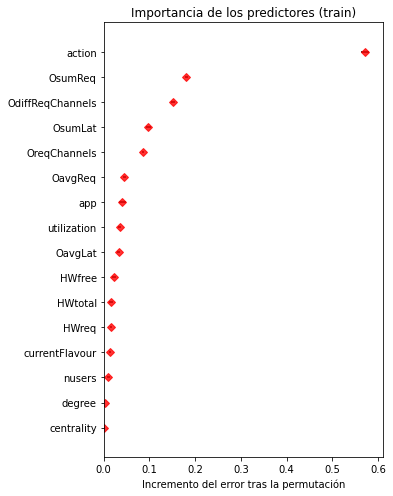

In [42]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 8))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

In [43]:
# Sample one
df.columns

Index(['app', 'currentFlavour', 'action', 'HWreq', 'OdiffReqChannels',
       'OreqChannels', 'OsumReq', 'OavgReq', 'OsumLat', 'OavgLat', 'HWtotal',
       'HWfree', 'utilization', 'degree', 'centrality', 'nusers', 'fit'],
      dtype='object')

In [61]:
actions_labels = ["undeploy","small","medium","large","migrate","replicate"]
sampleO = [1,actions_labels.index("small"),actions_labels.index("undeploy"),1,
           3,3,10,10,3,3,4,2,0.5,1,0.09,0]
print(len(sampleO))
sampleO = [1,actions_labels.index("small"),actions_labels.index("undeploy"),1,
           0,0, 0, 0,0,0,4,2,0.5,1,0,0]
print(len(sampleO))
#sampleF = [0,0,0,0,0,0,0,0,4,0,1,0.9,0]
#fact = sampleO+sampleF
fact = sampleO
print(fact)
print(len(fact))
col = df.columns[:-1]
print(len(col))
dftest = pd.DataFrame(columns=list(col))
dftest.loc[0]=fact
dftest.head()

16
16
[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 4, 2, 0.5, 1, 0, 0]
16
16


,app,currentFlavour,action,HWreq,OdiffReqChannels,OreqChannels,OsumReq,OavgReq,OsumLat,OavgLat,HWtotal,HWfree,utilization,degree,centrality,nusers
0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.5,1.0,0.0,0.0


In [62]:
forecasting = model.predict(X = dftest)
print(forecasting)

[1.]


In [64]:
# Iterating on all actions
actions_labels = ["undeploy","small","medium","large","migrate","replicate"]
for i in range(len(actions_labels)):
    print(" Action: %s"%actions_labels[i])
    sampleO = [1,actions_labels.index("small"),i,1,
           0,0,0,0,0,0,4,2,0.5,1,0,0]
    fact = sampleO
    col = df.columns[:-1]
    dftest = pd.DataFrame(columns=list(col))
    dftest.loc[0]=fact
    forecasting = model.predict(X = dftest)
    print(forecasting)


 Action: undeploy
[1.]
 Action: small
[0.]
 Action: medium
[0.]
 Action: large
[0.]
 Action: migrate
[0.]
 Action: replicate
[0.]


In [67]:
dd = df[df.fit==1]
dd.head()

,app,currentFlavour,action,HWreq,OdiffReqChannels,OreqChannels,OsumReq,OavgReq,OsumLat,OavgLat,HWtotal,HWfree,utilization,degree,centrality,nusers,fit
1,1,2,1,10,1,1,3,3.000000,4,4.000000,2.0,0,1.000000,1,0.076923,1,1.0
4,1,1,5,5,1,1,1,1.000000,7,7.000000,6.0,4,0.333333,4,0.307692,1,1.0
9,1,2,1,10,3,3,32,10.666667,4,1.333333,5.0,3,0.400000,5,0.384615,2,1.0
10,1,2,3,10,3,3,16,5.333333,4,1.333333,5.0,3,0.400000,5,0.384615,2,1.0
12,1,1,5,5,1,1,1,1.000000,7,7.000000,8.0,1,0.875000,3,0.230769,0,1.0


In [86]:
actions_labels = ["undeploy","small","medium","large","migrate","replicate"]
acts = collections.defaultdict(list)
col = df.columns[:-1]
for ix,row in dd.iterrows():
    sample = row.values[:-1]
    for i in range(len(actions_labels)):
        print(" Action: %s"%actions_labels[i])
        
        dftest = pd.DataFrame(columns=list(col))
        sample[2] = i #action is the new action
        dftest.loc[0]=sample
        print(dftest)
        forecasting = model.predict(X = dftest) #¡OBVIAMENTE PODRIA HACER UNA PREDCCION SOBRE UN GRAN DATAFRAME....
        acts[i].append(forecasting[0])
    break
    


 Action: undeploy
   app  currentFlavour  action  HWreq  OdiffReqChannels  OreqChannels  \
0  1.0             2.0     0.0   10.0               1.0           1.0   

   OsumReq  OavgReq  OsumLat  OavgLat  HWtotal  HWfree  utilization  degree  \
0      3.0      3.0      4.0      4.0      2.0     0.0          1.0     1.0   

   centrality  nusers  
0    0.076923     1.0  
 Action: small
   app  currentFlavour  action  HWreq  OdiffReqChannels  OreqChannels  \
0  1.0             2.0     1.0   10.0               1.0           1.0   

   OsumReq  OavgReq  OsumLat  OavgLat  HWtotal  HWfree  utilization  degree  \
0      3.0      3.0      4.0      4.0      2.0     0.0          1.0     1.0   

   centrality  nusers  
0    0.076923     1.0  
 Action: medium
   app  currentFlavour  action  HWreq  OdiffReqChannels  OreqChannels  \
0  1.0             2.0     2.0   10.0               1.0           1.0   

   OsumReq  OavgReq  OsumLat  OavgLat  HWtotal  HWfree  utilization  degree  \
0      3.0      3

In [83]:
acts

defaultdict(list, {0: [1.0], 1: [1.0], 2: [1.0], 3: [1.0], 4: [1.0], 5: [1.0]})